In [226]:
import torch
import torchvision
from torch.optim.sgd import SGD
import kornia
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyiqa
from losses import init_structure_loss
import os
from PIL import Image
from pidinet import PidiNetDetector

pidi = PidiNetDetector()

def tensor_to_numpy(tensor, normalize=False):
    out_np: np.ndarray = kornia.utils.tensor_to_image(tensor.to(device='cpu'))
    if normalize:
        min_val = np.min(out_np)
        max_val = np.max(out_np)
        if min_val == max_val:
            return out_np
        # Normalize the image to range [0, 1]
        out_np = (out_np - min_val) / (max_val - min_val)
    return out_np

def save_tensor_image(tensor, path, normalize=False):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    array = tensor_to_numpy(tensor, normalize)
    image = Image.fromarray(np.uint8(array * 255))
    image.save(path)

def imshow(input: torch.Tensor, normalize=False):
    # out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out = tensor_to_numpy(input, normalize)
    plt.imshow(out, cmap='gray')
    plt.axis("off")
    plt.show()

def image_refine(ref, edit, loss_fn, iteration, weight=1.0, v=False, v_iter=10, v_dir='experiments/temp'):
    edit_copy = edit.clone()
    edit_copy.requires_grad = True
    os.makedirs(os.path.join(v_dir, 'image'), exist_ok=True)
    os.makedirs(os.path.join(v_dir, 'grad'), exist_ok=True)

    for i in range(iteration):
        edit_copy.requires_grad = True
        optimizer = SGD(params=[edit_copy], lr=1e-1)
        optimizer.zero_grad()
        loss = weight * loss_fn(ref, edit_copy)
        loss.backward()
        optimizer.step()
        grad = edit_copy.grad
        edit_copy = torch.clamp(edit_copy.detach(), 0.0, 1.0)

        if v and i % v_iter == 0:
            print(f'{i} iter loss : {loss}')
            out_image_path = os.path.join(v_dir, 'image', f'{i}.png')
            out_grad_path = os.path.join(v_dir, 'grad', f'{i}.png')

            save_tensor_image(edit_copy, out_image_path)
            save_tensor_image(grad, out_grad_path, True)
    
    return edit_copy

In [227]:
def sobel_L1(ref, edit):
    ref_edge = kornia.filters.sobel(ref)
    edit_edge = kornia.filters.sobel(edit)
    # sig = torch.nn.Sigmoid()
    # ref_edge_mod = sig(10 * (ref_edge - 0.5))
    # edit_edge_mod = sig(10 * (edit_edge - 0.5))
    # ref_edge_mod = torch.where(ref_edge < 0.1, ref_edge*0.1, ref_edge)
    # edit_edge_mod = torch.where(edit_edge < 0.05, edit_edge*0.01, edit_edge)
    # ref_edge[ref_edge < 0.1] =  0.01 * ref_edge[ref_edge < 0.1]
    # edit_edge[edit_edge < 0.1] =  0.01 * edit_edge[edit_edge < 0.1]
    loss_fn = torch.nn.L1Loss()
    loss = loss_fn(ref_edge, edit_edge)
    # loss = loss_fn(ref_edge_mod, edit_edge)
    return loss

def sobel_gaussian_L1(ref, edit, kernel=33, sigma=(4,4)):
    ref_edge = kornia.filters.sobel(ref)
    edit_edge = kornia.filters.sobel(edit)
    ref_edge_mod = torch.where(ref_edge < 0.05, ref_edge*0.1, ref_edge)
    # edit_edge_mod = torch.where(edit_edge < 0.05, edit_edge*0.1, edit_edge)
    ref_gaussian = kornia.filters.gaussian_blur2d(ref_edge_mod, kernel, sigma)
    edit_gaussian = kornia.filters.gaussian_blur2d(edit_edge, kernel, sigma)
    loss_fn = torch.nn.L1Loss()
    loss = loss_fn(ref_gaussian, edit_gaussian)
    # loss = loss_fn(ref_edge_mod, edit_edge_mod)
    return loss

def sobel_soft_L1(ref,edit):
    ref_edge = kornia.filters.sobel(ref)
    edit_edge = kornia.filters.sobel(edit)
    sig = torch.nn.Sigmoid()
    ref_edge_mod = sig(10 * (ref_edge - 0.3))
    edit_edge_mod = sig(10 * (edit_edge - 0.3))
    # print(edit_edge_mod.max())
    # ref_edge_mod = torch.where(ref_edge < 0.1, ref_edge*0.1, ref_edge)
    # edit_edge_mod = torch.where(edit_edge < 0.05, edit_edge*0.01, edit_edge)
    # ref_edge[ref_edge < 0.1] =  0.01 * ref_edge[ref_edge < 0.1]
    # edit_edge[edit_edge < 0.1] =  0.01 * edit_edge[edit_edge < 0.1]
    loss_fn = torch.nn.MSELoss()
    # loss = loss_fn(ref_edge, edit_edge)
    loss = loss_fn(ref_edge_mod, edit_edge_mod)
    return loss

def canny_L1(ref, edit):
    ref_edge, _ = kornia.filters.canny(ref)
    edit_edge, _ = kornia.filters.canny(edit)
    loss_fn = torch.nn.MSELoss()
    loss = loss_fn(ref_edge, edit_edge)
    return loss

def pidi_L1(ref, edit):
    ref_edge = torch.clamp(pidi(ref), 0.0, 1.0)
    edit_edge = torch.clamp(pidi(edit), 0.0, 1.0)
    loss_fn = torch.nn.L1Loss()
    loss = loss_fn(ref_edge, edit_edge)
    return loss

class SSIM_Structure:
    def __init__(self, as_loss=True, **kwargs):
        if 'get_ssim_map' in kwargs:
            self.get_ssim_map = kwargs['get_ssim_map']
        self.l = pyiqa.create_metric('ssim_structure', device='cuda', as_loss=as_loss, **kwargs)
    
    def __call__(self, source, target):
        if hasattr(self, 'get_ssim_map') and self.get_ssim_map is True:
            ssim_val, ssim_map = self.l(source, target)
            self.ssim_map = ssim_map
            return 1. - ssim_val
        return 1. - self.l(source, target)

class G_SSIM_Structure:
    def __init__(self, as_loss=True, **kwargs):
        if 'get_ssim_map' in kwargs:
            self.get_ssim_map = kwargs['get_ssim_map']
        self.l = pyiqa.create_metric('ssim_structure', device='cuda', as_loss=as_loss, **kwargs)
    
    def __call__(self, source, target):
        source_edge = kornia.filters.sobel(source)
        target_edge = kornia.filters.sobel(target)
        if hasattr(self, 'get_ssim_map') and self.get_ssim_map is True:
            ssim_val, ssim_map = self.l(source_edge, target_edge)
            self.ssim_map = ssim_map
            return 1. - ssim_val
        return 1. - self.l(source_edge, target_edge)

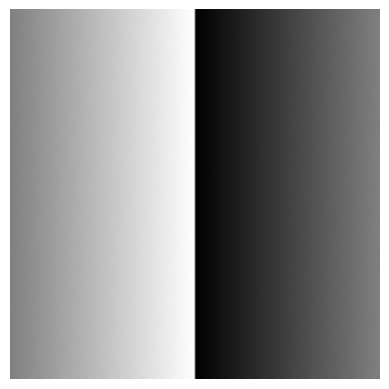

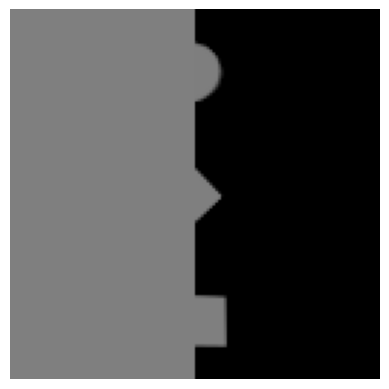

In [228]:
ref_tensor = kornia.io.load_image("images/edge_optimization_test/0_gradient.png", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
imshow(ref_tensor)
edit_tensor = kornia.io.load_image("images/edge_optimization_test/10.png", kornia.io.ImageLoadType.RGB32, device='cuda')[None, ...]  # BxCxHxW
imshow(edit_tensor)

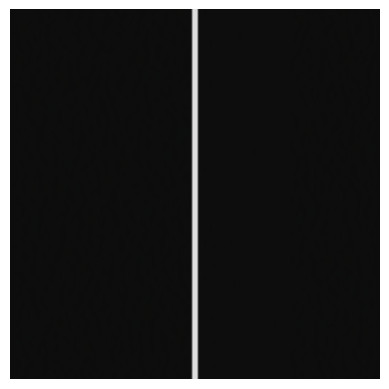

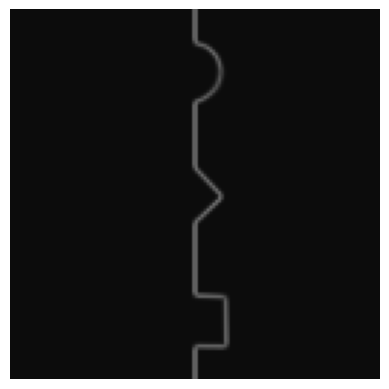

In [229]:
# ref_sobel = kornia.filters.sobel(ref_tensor)
# edit_sobel = kornia.filters.sobel(edit_tensor)
# imshow(ref_sobel)
# imshow(edit_sobel)
# save_tensor_image(ref_sobel, f'experiments/20240529_Sobel/alley_sobel.png')
# save_tensor_image(edit_sobel, f'experiments/20240529_Sobel/alley_fog_sobel.png')

sig = torch.nn.Sigmoid()
ref_sobel = kornia.filters.sobel(ref_tensor)
edit_sobel = kornia.filters.sobel(edit_tensor)
ref_sobel_mod = sig(10 * (ref_sobel - 0.3))
edit_sobel_mod = sig(10 * (edit_sobel - 0.3))
imshow(ref_sobel_mod)
imshow(edit_sobel_mod)
save_tensor_image(ref_sobel_mod, f'experiments/20240529_Sobel/0_gradient_sobel_soft.png')
save_tensor_image(edit_sobel_mod, f'experiments/20240529_Sobel/10_sobel_soft.png')

# ref_sobel_mod = torch.where(ref_sobel < 0.5, ref_sobel*0.1, ref_sobel)
# edit_sobel_mod = torch.where(edit_sobel < 0.05, edit_sobel*0.1, edit_sobel)
# ref_sobel_gaussian = kornia.filters.gaussian_blur2d(ref_sobel_mod, 33, (4,4))
# edit_sobel_gaussian = kornia.filters.gaussian_blur2d(edit_sobel_mod, 33, (4,4))
# imshow(ref_sobel_gaussian)
# imshow(edit_sobel_gaussian)
# save_tensor_image(ref_sobel_gaussian, f'experiments/20240529_Sobel_Gaussian/0_sobel_gaussian.png')
# save_tensor_image(edit_sobel_gaussian, f'experiments/20240529_Sobel_Gaussian/6_sobel_gaussian.png')

# ref_canny, ref_canny_edge = kornia.filters.canny(ref_tensor)
# edit_canny, edit_canny_edge = kornia.filters.canny(edit_tensor)
# imshow(ref_canny_edge)
# imshow(edit_canny_edge)
# save_tensor_image(ref_canny_edge, f'experiments/20240529_Canny/summer_canny_edge.png')
# save_tensor_image(edit_canny_edge, f'experiments/20240529_Canny/spring_canny_edge.png')
# imshow(ref_canny)
# imshow(edit_canny)
# save_tensor_image(ref_canny, f'experiments/20240529_Canny/summer_canny.png')
# save_tensor_image(edit_canny, f'experiments/20240529_Canny/spring_canny.png')

# ref_pidi = pidi(ref_tensor)
# edit_pidi = pidi(edit_tensor)
# imshow(ref_pidi)
# imshow(edit_pidi)
# save_tensor_image(ref_pidi, f'experiments/20240529_Pidi/0_pidi.png')
# save_tensor_image(edit_pidi, f'experiments/20240529_Pidi/10_pidi.png')

# ssim = SSIM_Structure(as_loss=False, get_ssim_map=True)
# ssim_score = ssim(ref_tensor, edit_tensor)
# ssim_map = ssim.ssim_map.clone()
# print(f'SSIM_structure : {ssim_score}')
# imshow(ssim_map)
# save_tensor_image(ssim_map, f'experiments/20240529_SSIM/winter_ssim.png', True)

# gssim = G_SSIM_Structure(as_loss=False, get_ssim_map=True)
# gssim_score = gssim(ref_tensor, edit_tensor)
# gssim_map = gssim.ssim_map.clone()
# print(f'G_SSIM_structure : {gssim_score}')
# imshow(gssim_map)
# save_tensor_image(gssim_map, f'experiments/20240529_G_SSIM/summer_gssim.png', True)


0 iter loss : 7.366850852966309
100 iter loss : 4.095849990844727
200 iter loss : 1.4607211351394653
300 iter loss : 1.012269377708435
400 iter loss : 0.8297454118728638
500 iter loss : 0.712664008140564
600 iter loss : 0.6290114521980286
700 iter loss : 0.5657870173454285
800 iter loss : 0.5176501870155334
900 iter loss : 0.4823014736175537
1000 iter loss : 0.45659494400024414
1100 iter loss : 0.435920387506485
1200 iter loss : 0.41838595271110535
1300 iter loss : 0.4030522108078003
1400 iter loss : 0.38930875062942505
1500 iter loss : 0.3773305416107178
1600 iter loss : 0.366611123085022
1700 iter loss : 0.3570738136768341
1800 iter loss : 0.3486662805080414
1900 iter loss : 0.34099647402763367
2000 iter loss : 0.33385714888572693
2100 iter loss : 0.32715824246406555
2200 iter loss : 0.32111653685569763
2300 iter loss : 0.31542906165122986
2400 iter loss : 0.31008973717689514
2500 iter loss : 0.3051702082157135
2600 iter loss : 0.30055010318756104
2700 iter loss : 0.2962108850479126


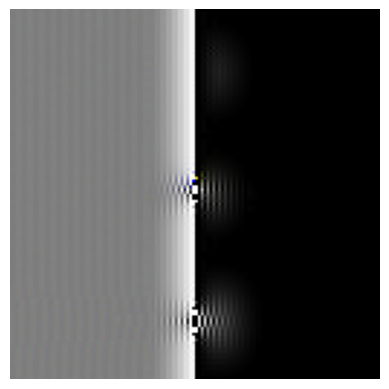

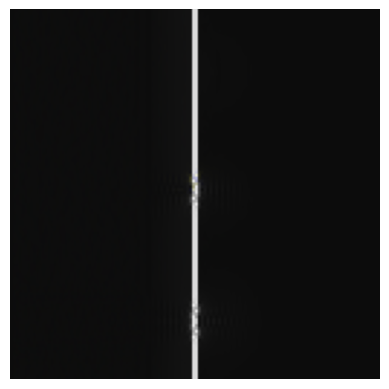

In [230]:
# edit_refine = image_refine(ref_tensor, edit_tensor, sobel_L1, 20000, 1000, True, 100, 'experiments/20240529_Sobel')
# edit_refine_sobel = kornia.filters.sobel(edit_refine)
# imshow(edit_refine)
# imshow(edit_refine_sobel)
# save_tensor_image(edit_refine, f'experiments/20240529_Sobel/spring_refine_sobel.png')
# save_tensor_image(edit_refine_sobel, f'experiments/20240529_Sobel/spring_refine_sobel_Sobel.png')

edit_refine = image_refine(ref_tensor, edit_tensor, sobel_soft_L1, 20000, 1000, True, 100, 'experiments/20240529_Sobel')
edit_refine_sobel = kornia.filters.sobel(edit_refine)
edit_refine_sobel_mod = sig(10 * (edit_refine_sobel - 0.3))
imshow(edit_refine)
imshow(edit_refine_sobel_mod)
save_tensor_image(edit_refine, f'experiments/20240529_Sobel/10_refine_sobel_soft.png')
save_tensor_image(edit_refine_sobel_mod, f'experiments/20240529_Sobel/10_refine_sobel_soft_Sobel.png')

# edit_refine = image_refine(ref_tensor, edit_tensor, sobel_gaussian_L1, 20000, 1000, True, 100, 'experiments/20240529_Sobel_Gaussian')
# edit_refine_sobel = kornia.filters.sobel(edit_refine)
# edit_refine_sobel_gaussian = kornia.filters.gaussian_blur2d(edit_refine_sobel, 11, (1,1))
# imshow(edit_refine)
# imshow(edit_refine_sobel)
# imshow(edit_refine_sobel_gaussian)

# edit_refine = image_refine(ref_tensor, edit_tensor, canny_L1, 1000, 1000, True, 100, 'experiments/20240529_Canny')
# edit_refine_canny, _ = kornia.filters.canny(edit_refine)
# imshow(edit_refine)
# imshow(edit_refine_canny)
# save_tensor_image(edit_refine, f'experiments/20240529_Canny/spring_refine_canny.png')
# save_tensor_image(edit_refine_canny, f'experiments/20240529_Canny/spring_refine_canny_Canny.png')

# edit_refine = image_refine(ref_tensor, edit_tensor, pidi_L1, 2000, 10, True, 10, 'experiments/20240529_Pidi')
# edit_refine_pidi = pidi(edit_refine)
# imshow(edit_refine)
# imshow(edit_refine_pidi)
# save_tensor_image(edit_refine, f'experiments/20240529_Pidi/10_refine.png')
# save_tensor_image(edit_refine_pidi, f'experiments/20240529_Pidi/10_refine_pidi.png')

# ssim_structure = SSIM_Structure()
# edit_refine = image_refine(ref_tensor, edit_tensor, ssim_structure, 1000, 200, True, 100, 'experiments/20240529_SSIM')
# imshow(edit_refine)
# edit_refine_ssim_score = ssim(ref_tensor, edit_refine)
# edit_refine_ssim_map = ssim.ssim_map.clone()
# print(f'SSIM_structure : {edit_refine_ssim_score}')
# imshow(edit_refine_ssim_map)
# save_tensor_image(edit_refine, f'experiments/20240529_SSIM/winter_refine_ssim.png')
# save_tensor_image(edit_refine_ssim_map, f'experiments/20240529_SSIM/winter_refine_ssim_SSIM.png', True)

# g_ssim_structure = G_SSIM_Structure()
# edit_refine = image_refine(ref_tensor, edit_tensor, g_ssim_structure, 10000, 100, True, 100, 'experiments/20240529_G_SSIM')
# imshow(edit_refine)
# edit_refine_gssim_score = gssim(ref_tensor, edit_refine)
# edit_refine_gssim_map = gssim.ssim_map.clone()
# print(f'G_SSIM_structure : {edit_refine_gssim_score}')
# imshow(edit_refine_gssim_map)
# save_tensor_image(edit_refine, f'experiments/20240529_G_SSIM/spring_refine_gssim.png')
# save_tensor_image(edit_refine_gssim_map, f'experiments/20240529_G_SSIM/spring_refine_gssim_G_SSIM.png', True)